# Linear Classification prediction project (Forest Cover Classification)

This jupyter notebook covers the analys made for predicting the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

Further details on the data could be found in the next link https://archive.ics.uci.edu/ml/datasets/Covertype

This notebook shows the steps followed in order to predict the cover type using the Logistic Regression models for two differents kinds a of classification task, a binary task in which I want to predict cover type 7 - Krummholz, and a multiclass classification taks in which I want to predict the forest cover kind that is predominant given the cartographic and enviromental variables.

The 7 kinds of forest cover are:

- 1 - Spruce/Fir
- 2 - Lodgepole Pine
- 3 - Ponderosa Pine
- 4 - Cottonwood/Willow
- 5 - Aspen
- 6 - Douglas-fir
- 7 - Krummholz

## Loading the modules

In [144]:
import os

In [145]:
import sys
sys.path.append('src/other_functions')

In [171]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style("white")

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score

import imblearn
from imblearn.over_sampling import SMOTE

import joblib

In [147]:
# Jack's module
import helper_functions as hf

In [148]:
# Own modules
import features
from features import build_y_X, reweight_proba, PolyFeatures

import customplots
from customplots import target_features_plot, grid_serach_dt

## Predict if the cover class is 7 - Krummholz

In this section I will show the steps for predicting with around a 0.98 value of the area under the curve the binary unbalanced classes for cover type 7 against the other cover types.

### Loading the data

In [149]:
df_train = pd.read_csv('data/input/MultiClass_Train_index.csv')
df_test = pd.read_csv('data/input/MultiClass_Test.csv')

print(df_train.shape)
print(df_test.shape)

print('in train not in test')
print([i for i in df_train.columns if i not in [i for i in df_test.columns]])

print('in test not in train')
print([i for i in df_test.columns if i not in [i for i in df_train.columns]])

(61006, 14)
(13073, 13)
in train not in test
['Cover_Type']
in test not in train
[]


The number of observations to predict is around the 21% of the total rows that we have in the training data set. Only cover type (our target variable) is the one that is not in the test set.

### Brief data exploration

In [78]:
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Index                  13073 non-null  int64
 1   Elevation              13073 non-null  int64
 2   Aspect                 13073 non-null  int64
 3   Slope                  13073 non-null  int64
 4   Horiz_dist_hydro       13073 non-null  int64
 5   Vertical_dist_hydro    13073 non-null  int64
 6   Horiz_dist_roadways    13073 non-null  int64
 7   Hillshade_9am          13073 non-null  int64
 8   Hillshade_Noon         13073 non-null  int64
 9   Hillshade_3pm          13073 non-null  int64
 10  Horiz_dist_firepoints  13073 non-null  int64
 11  Wilderness_Area        13073 non-null  int64
 12  Soil_Type              13073 non-null  int64
dtypes: int64(13)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61006 entries, 0 to 61005
Data columns (total 1

According with the report from pandas info() method, there are no missing data and all of the columns have a numeric format. However, according to the description form the repository of the data, Wilderness_Area and Soil_Type are categorical variables.

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64


<AxesSubplot:ylabel='Cover_Type'>

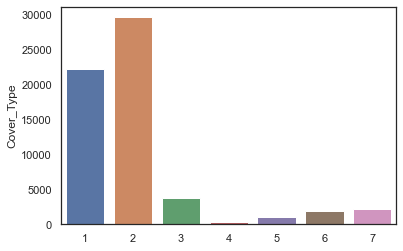

In [79]:
# Target variable
target_values = df_train['Cover_Type'].value_counts()
print(target_values)
sns.barplot(x=target_values.index, y=target_values)

As can be see in the plot avobe the distribution of the classes is highly imbalanced, which will make our goal more challenging.

In [150]:
# Creation of only one data frame
df_train['From'] = 'train'
df_test['From'] = 'test'
df = pd.concat([df_train, df_test], axis=0)
print(df.shape)
df.head()

(74079, 15)


,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type,From
0,0,3202,34,10,0,0,2760,219,218,134,1734,1.0,3,38,train
1,1,3113,251,13,192,40,5600,191,249,195,2555,2.0,1,22,train
2,2,2801,77,9,510,17,1728,232,223,122,1087,2.0,1,12,train
3,3,3165,82,9,319,56,4890,233,225,124,1452,1.0,1,29,train
4,4,3048,333,11,124,31,2823,196,226,170,666,1.0,1,23,train


In [7]:
# Unique values per column
df.nunique()

Index                    74079
Elevation                 1739
Aspect                     361
Slope                       58
Horiz_dist_hydro           472
Vertical_dist_hydro        566
Horiz_dist_roadways       5268
Hillshade_9am              189
Hillshade_Noon             161
Hillshade_3pm              251
Horiz_dist_firepoints     5111
Cover_Type                   7
Wilderness_Area              4
Soil_Type                   39
From                         2
dtype: int64

Index has unique values for every row which indicates that this columns in the id for every observation.

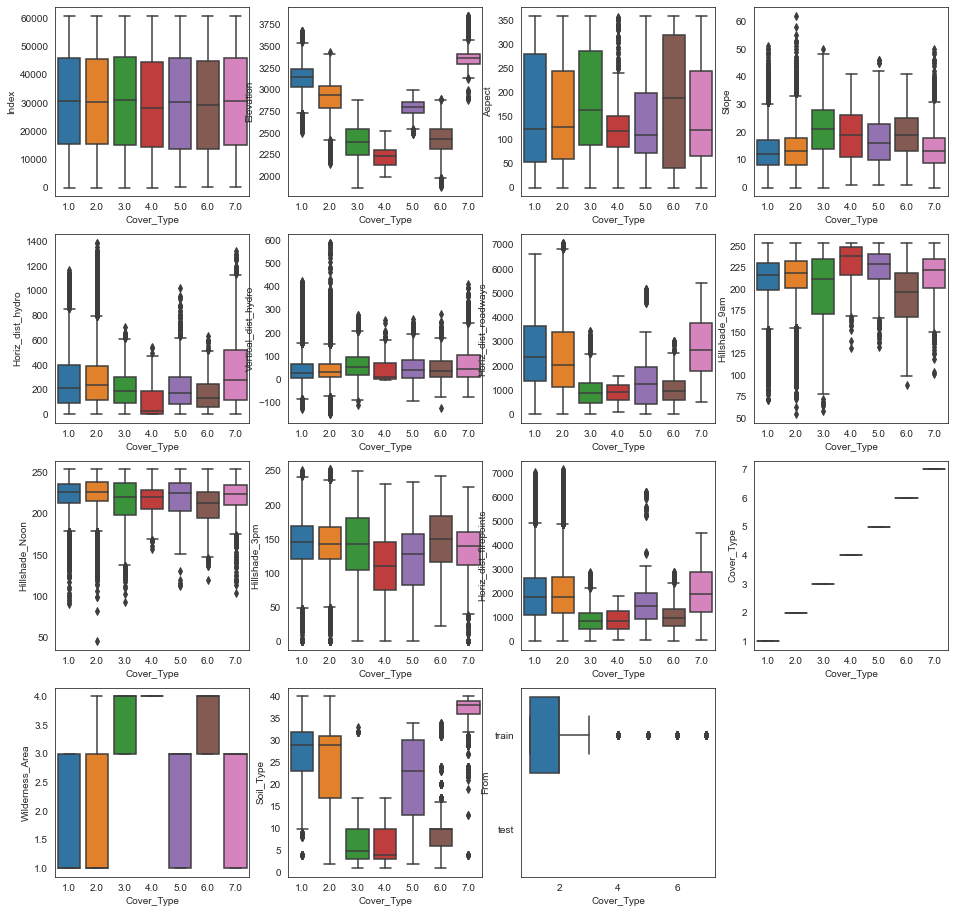

In [12]:
target_features_plot(df, 'Cover_Type', df.columns, 'boxplot')

From the plots above we can see that Elevation, Wilderness_Are and perhaps Soit_Type can be good predictors of each class, since its distribution in differentes for certain values of cover type. It's courius because Wilderness_Are Soit_Type should be used as categories but using them as numerical features, we can find a correlation with Cover_type, mainly in Soil_type.

Let's see now, the distribution of the features for the binary class classification to predict cover type 7.

In [240]:
# Create the label to predict (binary task)
print(df['Cover_Type'].value_counts())
df['target'] = np.where(df['Cover_Type'].isin([1,2,3,4,5,6]),0,
                       np.where(df['Cover_Type']==7,1,np.nan))
# Clean observations of test 
print(df['target'].value_counts())

2.0    29690
1.0    22199
3.0     3802
7.0     2163
6.0     1865
5.0      992
4.0      295
Name: Cover_Type, dtype: int64
0.0    58843
1.0     2163
Name: target, dtype: int64


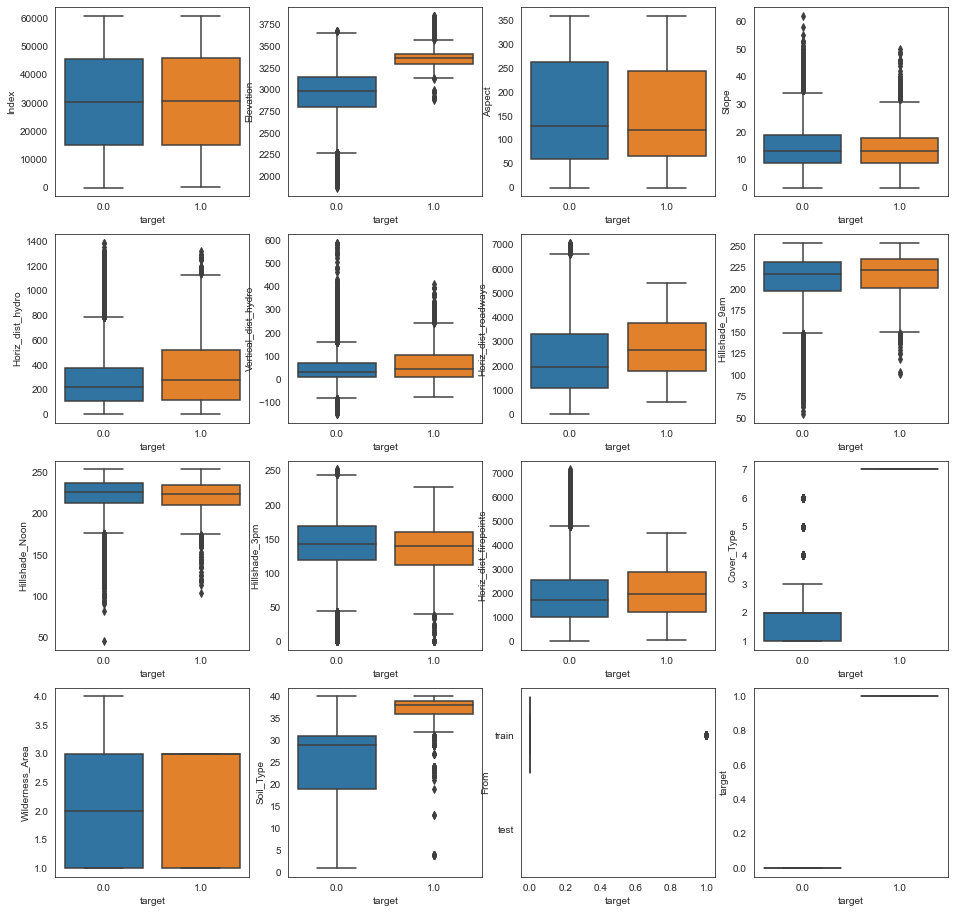

In [7]:
target_features_plot(df, 'target', df.columns, 'boxplot')

When searching for relation between the features of our data set to predict if the cover type is 7 or not. We can see that the distribution of the features elevation, Horiz_dist_roadways and Soil_Type is differente between our binary target. 

There are also, slight differences in the median between groups of our target variables in other variables like Aspect, Horiz_dist_roadways, Vertical_dist_hydro, Horiz_dist_firepoints.

Under the analysis done so far, I have enought elements to run a first model and checking the accuracy and perfomance of this model to build predictions.

### Model 1

In the in-class predictions I only created the dummy variables for the two categorical columns ('Wilderness_Area', 'Soil_Type']), ran the logit with default parameters and solve the imbalance class by using the balance property in sklearn and by applying the function to re-scale probability. 

In this new predictions I want to create new features and doing grid search.

In [152]:
# Index as index
df.set_index('Index', inplace=True)

In [153]:
# New data set and deleting the cover type
df2 = df.copy()
df2.drop('Cover_Type', axis=1, inplace=True)

# Soil type twice, one for using as numeric (N) and the other one to create dummies
df2['Soil_Type_N'] = df2['Soil_Type'] 

Once I have the features I want to work with, the next step is to prepare the train and test columns. For this I create a function in my features module that split the data into test and training, build dummies according to a list of features given and re-escale the data using the StandardScaler from sklearn.

In [154]:
# Building X's and y with the function of the module features
y_train, X_train, X_test = build_y_X(df2, ['Wilderness_Area', 'Soil_Type'], 'target', 'From')
print(y_train.shape, X_train.shape, X_test.shape)

(61006,) (61006, 54) (13073, 54)


#### Grid search to find the 'penalty' and 'C'

Using the method LogisticRegression from Skelearn.linear_model and GridSearchCV from sklearn.model_selection I want to find the best hyperparameters for regularization will help to avoid overfit in this kind of tasks in which the goal is to make good predictions.

Among the values to choose for penalty we have 'l1' Lasso and 'l2' Ridge, what these methods do is two modify the lost function of the model in order to shrinkage the value of the regression parameters and building models that generalize better over unobserved data.

Since the Loss function of the Logistic Regression is as follows:

$$L(b) = \sum_i \log (1+e^{-f(x_i,b)}) + y_i f(x_i,b) + \alpha |\beta|$$

With Lasso and Ridge shrinkage methods the Loss functions that skelearn uses for '11' and 'l2' parameters are: 

$$L(b) + c |\beta| $$

and 

$$L(b) + c \beta^2 $$

respectevely, where c is the inverse of regularization strength ($c = 1/\alpha$ for alpha the regularization strenght). 

According to the above as C increases the regularization imposed over the model decreases and the other way around for small values of C.

The next lines of code show how to find the best values for c in both of the regularization (or shrinkage) methods using cross validation.

In [82]:
# Running the grid search

lr_1 = LogisticRegression( fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')
                           #n_jobs=-1)

alphas = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 150])

tuned_parameters = [{'penalty': ['l1','l2'], 'C': alphas}] 

n_folds = 5

lr_gs1 = GridSearchCV(lr_1, tuned_parameters, cv=n_folds, scoring='roc_auc', refit=False, verbose = 3)

In [83]:
lr_gs1.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .............................C=0.01, penalty=l1; total time=   0.7s
[CV 2/5] END .............................C=0.01, penalty=l1; total time=   0.7s
[CV 3/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 4/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 5/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 1/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 2/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 3/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 4/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 5/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 1/5] END .............................C=0.05, penalty=l1; total time=   1.2s
[CV 2/5] END .............................C=0.05

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, solver='liblinear'),
             param_grid=[{'C': array([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01,
       1.0e+02, 1.5e+02]),
                          'penalty': ['l1', 'l2']}],
             refit=False, scoring='roc_auc', verbose=3)

{'C': 0.5, 'penalty': 'l2'}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

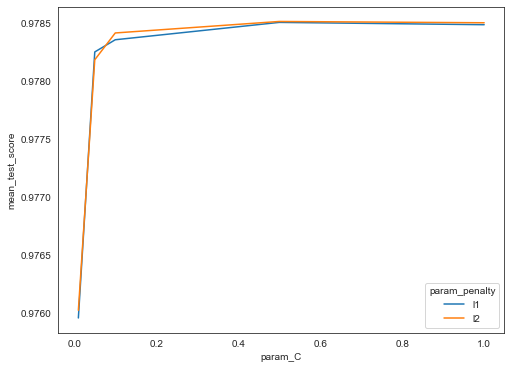

In [285]:
print(lr_gs1.best_params_)
cv_results_gs1 = pd.DataFrame(lr_gs1.cv_results_)
plt.figure(figsize=(8,6))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data = cv_results_gs1[cv_results_gs1['param_C']<=1])

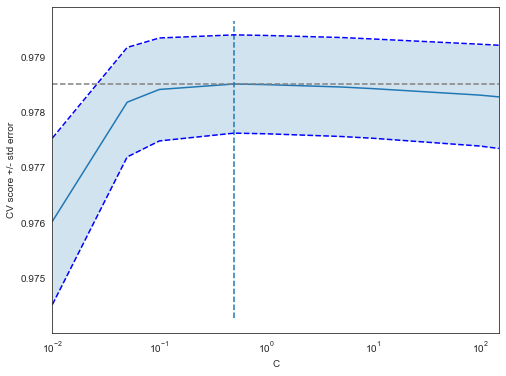

In [287]:
# Detailed results of grid search over penalty l1
best_params_gs1 = lr_gs1.best_params_['C']
scores_gs1 = cv_results_gs1[cv_results_gs1['param_penalty'] == 'l2']['mean_test_score']
std_error_gs1 = cv_results_gs1[cv_results_gs1['param_penalty'] == 'l2']['std_test_score']
alphas_gs1 = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 150])

grid_serach_dt(scores_gs1, std_error_gs1, alphas_gs1, best_params_gs1)

#### Best model according with Grid Search

After running 90 different fits the best hypeparameters are penalty 'l2' (Ridge) with a value of C of 0.5. With these hyperparamenters the value of the area under the curve is the largest.  Whith this information I re run a the logistic regression and compute some metrics to evaluate the model.

In [120]:
# Running the model with the best hyperparameters according with the grid search
lr_11 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')


# Fiting logistic regression
lr_11.fit(X_train, y_train)      

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   solver='liblinear')

Since the LogisticRegression method has class_weight='balanced', sklearn is re-sampling the data set to build a new data frame with equal number of rows for each class (re-sampling the smaller classes). This tranformation on the data  biases the probabilities for each class since the model was training using balanced data, but the predictions should be done over unbalanced data. 

For this reason the default probabilities of the class predict_proba from LogisticRegression are adjusted by the next expression:

  $$ { \pi(y_i) {q(y_i) \over r(y_i)} \over \pi(1) {q(1) \over r(1)} + \pi(0) {q(0) \over r(0)}}$$
  
The following function, takes as arguments the model and the test and training data set and returns the adjusted probabilities for both data sets.

In [14]:
# Function for predictions
def pred_with_reweight(model, X_train, X_test):
    # Predictions and probabilities for test and training
    y_h_tr = model.predict(X_train)
    y_h_tr_p = model.predict_proba(X_train)
    y_h_te = model.predict(X_test)
    y_h_te_p = model.predict_proba(X_test)
    
    # Reweigths of the probabilities
    q1 = y_train.sum()/len(y_train) # Proportions of 1
    r1 = 0.5 

    y_h_tr_p_rw = reweight_proba(y_h_tr_p, q1, r1) # uses the function 'reweight_probashown' shown in class
    y_h_te_p_rw = reweight_proba(y_h_te_p, q1, r1)
    
    return y_h_tr_p_rw, y_h_te_p_rw, y_h_tr_p, y_h_te_p, y_h_tr, y_h_te

In [122]:
y_hat_train_p1, y_hat_test1, _, _, _, _ = pred_with_reweight(lr_11, X_train, X_test) # Returns adjusted predicted probabilities over train and test data

#### Model evaluation

To evaluate the model, I am using the area under the ROC (Receiver Operating Characteristics) curve which is one of the best strategies for model evaluation in a binary class task. In few words, the ROC curve is the relation between the true positive rate (proportion of observations correctly classified as True: TPR) and the false positive rate (proportion of observation incorrectly classified as positive: FPR). Since TPR and FPR are both sensitive to the probability's cutoff to assing a class, this  curve measures the hability of the model to distingish between classes and any given threshold. 

The Higher the AUC, the better the model is at distinguishing the classes

AUC:  0.9791300984136155


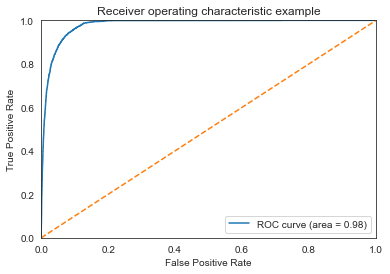

In [123]:
hf.get_auc(y_train, y_hat_train_p1, ['0','1'], column=1, plot=True)

#### Features importance

In other to give insigths about the relation of Cover type with the features of the data set, the next plot shows the feature importance.

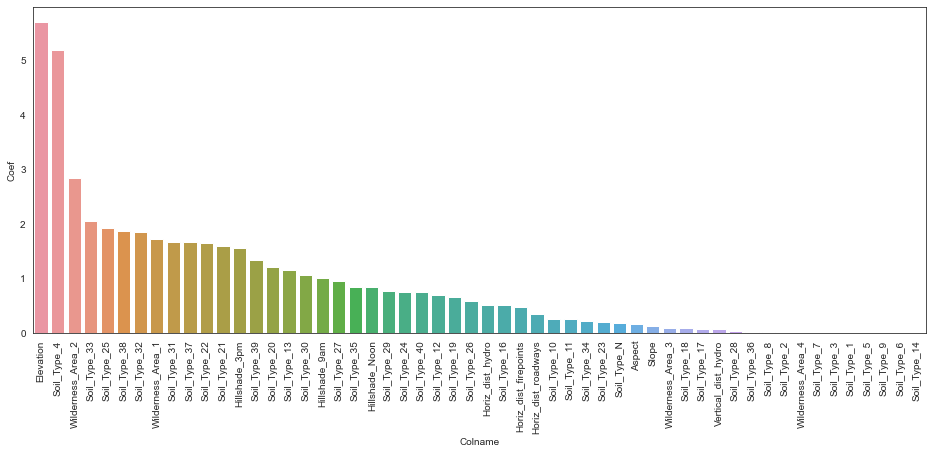

In [92]:
# Plot of variables impact
cp.col_import_plot(X_train.columns, lr_11.coef_.reshape(-1,))

By looking at the variables impact of the model (size of betas for each feature), we see as expected that Elevation plays a important role in spliting the classes. Soil Type and Wilderness area as we saw in the exploratory analysis also are good predictos for the cover type 7 or other.

Finally I want to save the model and the data used in order to be able to replicate results in the future. I also going to export the predicted probabilities in the test data to submit the predictions and get information from the public leaderboard.

In [16]:
# Saving the model and the data
joblib.dump(lr_11, 'models/lr_11.sav')

# Saving the data that the model uses
X_train.to_csv('data/output/lr_11_X_train.csv', index=False)
y_train.to_csv('data/output/lr_11_y_train.csv', index=False)
X_test.to_csv('data/output/lr_11_X_test.csv', index=False)

# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": X_test.index, "Cover_Type": y_hat_test1})
test_predictions_submit.to_csv("data/output/lr_11_y_hat_test.csv", index = False)

The value of the AUC of this model in the test data according with the public leaderboard of the kaggle competition is 0.98245, similar to the one in the insampole validation (0.9791).

### Model 2

I will run a second model in which I will create more features in other to find non-lienar associations between the features and the target variable

In [155]:
df3 = df2.copy()
print(df3.shape)
df3.head()

(74079, 15)


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type,From,target,Soil_Type_N
Index,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,3,38,train,0.0,38
1,3113,251,13,192,40,5600,191,249,195,2555,1,22,train,0.0,22
2,2801,77,9,510,17,1728,232,223,122,1087,1,12,train,0.0,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,29,train,0.0,29
4,3048,333,11,124,31,2823,196,226,170,666,1,23,train,0.0,23


For all the numeric features I am going to create their polinomial transformations using the class PolyFeatures from the model features.

Using this class I will add each variable to the power of 2 and 3, adding 22 new variables to the data frame.

In [156]:
# Polynomial features
poly_columns = ['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Soil_Type_N']

print(df3.shape)

df3 = PolyFeatures(n_poly_f = 3).transform(df3.copy(), poly_columns)
print(df3.shape)
df3.head()

(74079, 15)
(74079, 37)


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Hillshade_9am_poly2,Hillshade_9am_poly3,Hillshade_Noon_poly2,Hillshade_Noon_poly3,Hillshade_3pm_poly2,Hillshade_3pm_poly3,Horiz_dist_firepoints_poly2,Horiz_dist_firepoints_poly3,Soil_Type_N_poly2,Soil_Type_N_poly3
Index,,,,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,...,47961,10503459,47524,10360232,17956,2406104,3006756,5213714904,1444,54872
1,3113,251,13,192,40,5600,191,249,195,2555,...,36481,6967871,62001,15438249,38025,7414875,6528025,16679103875,484,10648
2,2801,77,9,510,17,1728,232,223,122,1087,...,53824,12487168,49729,11089567,14884,1815848,1181569,1284365503,144,1728
3,3165,82,9,319,56,4890,233,225,124,1452,...,54289,12649337,50625,11390625,15376,1906624,2108304,3061257408,841,24389
4,3048,333,11,124,31,2823,196,226,170,666,...,38416,7529536,51076,11543176,28900,4913000,443556,295408296,529,12167


Now I want to create features based in the interactios of Elevation with other dummy variables. However, first I am going to make the train and test data with scaled features.

In [157]:
# Interaction but using also the dummies vars and the features aready scaled
y_train, X_train_2, X_test_2 = ft.build_y_X(df3, ['Wilderness_Area', 'Soil_Type'], 'target', 'From')
print(y_train.shape, X_train_2.shape, X_test_2.shape)

(61006,) (61006, 76) (13073, 76)


In [158]:
# Interactions between Elevation and the most important columns according with Model 1
most_impor_cat_vars = ['Soil_Type_4', 'Wilderness_Area_2', 'Soil_Type_33', 'Soil_Type_25', 'Soil_Type_38',
'Soil_Type_32', 'Wilderness_Area_1', 'Soil_Type_31', 'Soil_Type_37', 'Soil_Type_22']

for col in most_impor_cat_vars:
    X_train_2['Ele_'+str(col)] = X_train_2['Elevation'] * X_train_2[col]
    X_test_2['Ele_'+str(col)] = X_test_2['Elevation'] * X_test_2[col]

print(X_train_2.shape)
print(X_test_2.shape)

(61006, 86)
(13073, 86)


#### Grid search to find the best model

Similar to what was done in model two I am going to find the best type of regularization with its own size (c)

In [257]:
# Running the grid search
lr_2 = LogisticRegression( fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')

alphas = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])

tuned_parameters = [{'penalty': ['l1','l2'], 'C': alphas}] 

n_folds = 5

lr_gs2 = GridSearchCV(lr_2, tuned_parameters, cv=n_folds, scoring='roc_auc', refit=False, verbose = 3)

In [258]:
lr_gs2.fit(X_train_2, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END .............................C=0.01, penalty=l1; total time=   3.4s
[CV 2/5] END .............................C=0.01, penalty=l1; total time=   3.2s
[CV 3/5] END .............................C=0.01, penalty=l1; total time=   4.3s
[CV 4/5] END .............................C=0.01, penalty=l1; total time=   4.1s
[CV 5/5] END .............................C=0.01, penalty=l1; total time=   3.3s
[CV 1/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 2/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 3/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 4/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 5/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 1/5] END .............................C=0.05, penalty=l1; total time=  22.4s
[CV 2/5] END .............................C=0.0

[CV 2/5] END ..............................C=1.0, penalty=l1; total time= 3.5min
[CV 3/5] END ..............................C=1.0, penalty=l1; total time= 3.6min
[CV 4/5] END ..............................C=1.0, penalty=l1; total time= 3.7min
[CV 5/5] END ..............................C=1.0, penalty=l1; total time= 3.2min
[CV 1/5] END ..............................C=1.0, penalty=l2; total time=   1.9s
[CV 2/5] END ..............................C=1.0, penalty=l2; total time=   2.0s
[CV 3/5] END ..............................C=1.0, penalty=l2; total time=   1.8s
[CV 4/5] END ..............................C=1.0, penalty=l2; total time=   1.7s
[CV 5/5] END ..............................C=1.0, penalty=l2; total time=   2.0s
[CV 1/5] END ..............................C=5.0, penalty=l1; total time= 6.8min
[CV 2/5] END ..............................C=5.0, penalty=l1; total time= 6.8min
[CV 3/5] END ..............................C=5.0, penalty=l1; total time= 5.0min
[CV 4/5] END ...............

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, solver='liblinear'),
             param_grid=[{'C': array([1.e-02, 5.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 1.e+00, 5.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2']}],
             refit=False, scoring='roc_auc', verbose=3)

{'C': 5.0, 'penalty': 'l1'}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

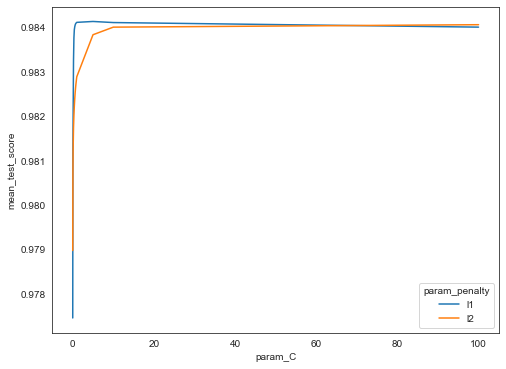

In [291]:
print(lr_gs2.best_params_)
cv_results_gs2 = pd.DataFrame(lr_gs2.cv_results_)
plt.figure(figsize=(8,6))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data = cv_results_gs2[cv_results_gs2['param_C']<1000])

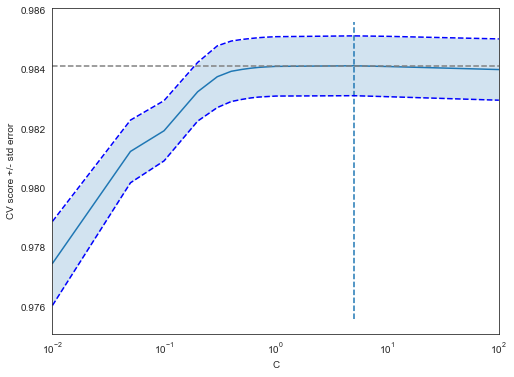

In [290]:
# Detailed reulst of grid search over penalty l1
best_params_gs2 = lr_gs2.best_params_['C']
scores_gs2 = cv_results_gs2[cv_results_gs2['param_penalty'] == 'l1']['mean_test_score']
std_error_gs2 = cv_results_gs2[cv_results_gs2['param_penalty'] == 'l1']['std_test_score']
alphas_gs2 = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])

cp.grid_serach_dt(scores_gs2, std_error_gs2, alphas_gs2, best_params_gs2)

The addition of new features increased the running time of each model. It also show us now, that the best hyperparameters are the Lasso method with a value of C of 5 (alpha of 0.2).

#### Running the best model from Grid Search

In [261]:
# Running the model with the best hyperparameters according with the grid search
lr_21 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l1',
                           C = 5,
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')


# Fiting logistic regression
lr_21.fit(X_train_2, y_train)      

LogisticRegression(C=5, class_weight='balanced', max_iter=10000, penalty='l1',
                   solver='liblinear')

In [262]:
# Predicted proba in test and training data
y_hat_train_p2, y_hat_test2, _, _, _, _ = pred_with_reweight(lr_21, X_train_2, X_test_2)

#### Model evaluation

AUC:  0.9851007180700859


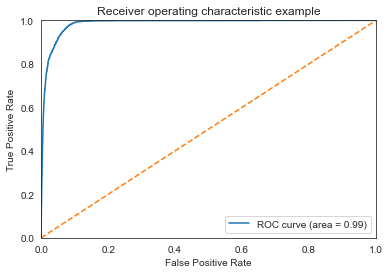

In [263]:
hf.get_auc(y_train, y_hat_train_p2, ['0','1'], column=1, plot=True)

With the addition of the new features the insample performace of the model, according with the AUC has improved from 0.979 to 0.985

#### Features importance

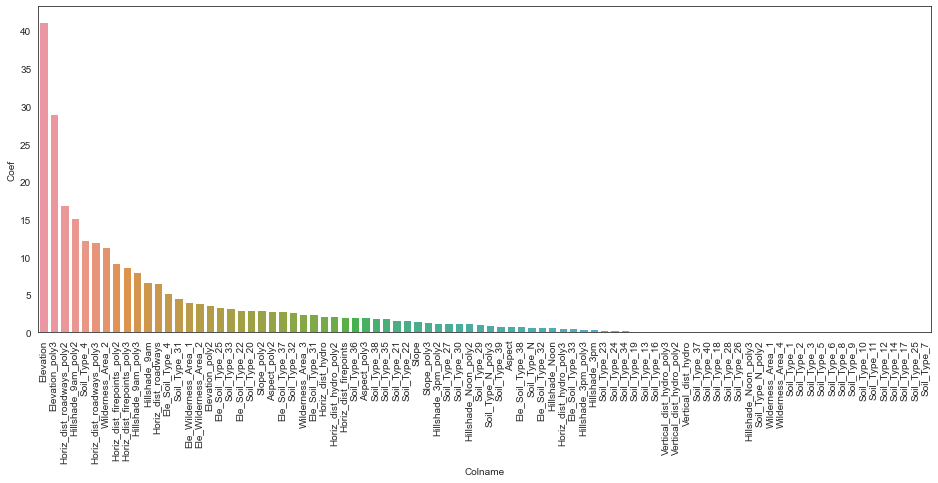

In [264]:
# Features importance
cp.col_import_plot(X_train_2.columns, lr_21.coef_.reshape(-1,))

With the new features, the main predictors are Elevation as before, and the polinomial transformation of Elevation to the power of 3. However other cuadratic transformations suchs as the Hori_dist_roadways and Hillshade_9am are also imoportant for this classification problem.

Now lets save the model and upload the predictions to the kaggle competition.

In [267]:
# Saving the model and the data
joblib.dump(lr_21, 'models/lr_21.sav')

# Saving the data that the model uses
X_train_2.to_csv('data/output/lr_21_X_train.csv', index=False)
y_train.to_csv('data/output/lr_21_y_train.csv', index=False)
X_test_2.to_csv('data/output/lr_21_X_test.csv', index=False)

# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_hat_test2[:,1]})
test_predictions_submit.to_csv("data/output/lr_21_y_hat_test.csv", index = False)

This last model gets an AUC of 0.98682 according with the public leaderboard of the kaggle competence.

# Multiclass classification

Now, the goal is to build a model that correctly distingish all of seven cover types that the data has. Remember that the cover types are:

- 1 - Spruce/Fir
- 2 - Lodgepole Pine
- 3 - Ponderosa Pine
- 4 - Cottonwood/Willow
- 5 - Aspen
- 6 - Douglas-fir
- 7 - Krummholz

### Loading the data again

In [183]:
df_train = pd.read_csv('data/input/MultiClass_Train_index.csv')
df_test = pd.read_csv('data/input/MultiClass_Test.csv')

### Model 1 

The first multiclass model that I what to run is one with the same features as the last (and best) model for binary classification. First, lets see a bit about the distribution of cover type and how much the classes are unbalanced

   Cover_Type  Cover_Type
2       29690   48.667344
1       22199   36.388224
3        3802    6.232174
7        2163    3.545553
6        1865    3.057076
5         992    1.626070
4         295    0.483559


<AxesSubplot:ylabel='Cover_Type'>

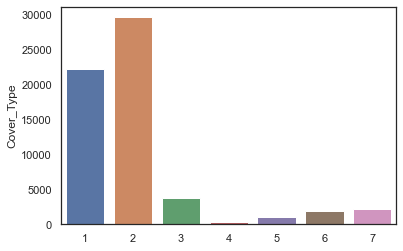

In [160]:
# Target variable distribution
target_values = df_train['Cover_Type'].value_counts()
target_values_per = (df_train['Cover_Type'].value_counts()/df_train.shape[0]) * 100
df_multi_target = pd.concat([target_values, target_values_per],axis=1)
print(df_multi_target)
sns.barplot(x=target_values.index, y=target_values)

As we can see above the different classes of Cover Types are highly imbalanced, specialy the class 4 that represents less than 0.5% of the total rows of training data. On the contrary, cover type == 2 represents almost 50% of all of the observations in the data for training our model.

In [161]:
# Lets run a simple model, which will work as the base line model
# I will use the data used in the last model (model 2) for binaty task, adding the y multi class

print(X_train_2.shape)
X_train_3 = pd.merge(X_train_2,  df_train.set_index('Index')['Cover_Type'], left_index = True, right_index = True) 
print(X_train_3.shape)

# Go back by creating y and droping Cove_type
y_train_m = X_train_3['Cover_Type']
X_train_3.drop('Cover_Type', axis=1, inplace=True)

print(X_train_3.shape, X_train_2.shape, y_train_m.shape)

(61006, 86)
(61006, 87)
(61006, 86) (61006, 86) (61006,)


In [20]:
lr_31 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', 
                           max_iter=10000,
                           class_weight='balanced')

# Fiting logistic regression
lr_31.fit(X_train_3, y_train_m)   

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

#### Model evaluation in default predictions

As in the binary class fit, this time I am also using the option class_weight='balanced' which re-samples the data for finding the best parameters of the model, but biases the predictions. Lets look and what is the distribution of the predictions in the training data.

1    21747
2    19801
5     7077
7     4781
6     3450
3     3319
4      831
dtype: int64


<AxesSubplot:>

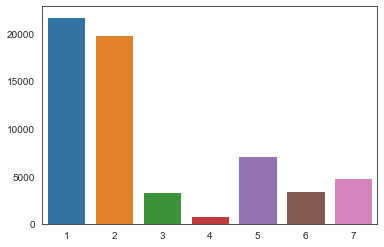

In [21]:
# Default class predictions on training data
y_h_train3_m_v = pd.Series(lr_31.predict(X_train_3))
y_h_train3_m_v_vc = y_h_train3_m_v.value_counts()
print(y_h_train3_m_v_vc)
sns.barplot(x=y_h_train3_m_v_vc.index, y=y_h_train3_m_v_vc)

From the graph above we can see that the distribution of the classes is very different to the original values in the trainign data. However let's go further to compare the predicted values against the actual values.

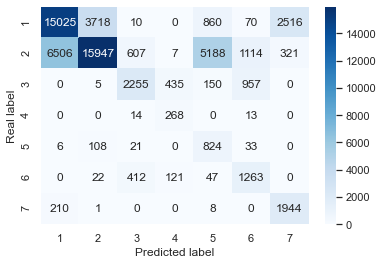

In [346]:
cm =  confusion_matrix(y_pred=y_h_train3_m_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) 

From the confusion matrix we see that the model makes many mistakes, mainly at predicting classes 1, 2, and 5. However let's see how much it can improve by adjusting the probabilities and the predicted class values.

#### Predictions adjustment and model evaluation

Similar to what was done for the binary classification here we also have to adjust the predicted probabilities, the mathematical formula for the new probabilities is the next one:

$$ { \pi(y_k) {q(y_k) \over r(y_k)} \over \pi(1) {q(1) \over r(1)} + \pi(2) {q(2) \over r(2)} + ...  + \pi(k) {q(k) \over r(K) }} $$

for k = 1,2,3,4,5..., K with K the total number of different classes, $q_k$ is the population proportion of each class and $r_ik$ the proportion of each class in the balanced data set (1/K)

The next function adjust the probabilities according with the formula above for any matrix pi of probabilities of shape $n$ x $K$ for $K > 2$.

In [48]:
def reweight_proba_multy(pi, q, r):
    pi_rw = pi.copy()
    tot = np.dot(pi, (np.array(q)/r))
    for i in range(len(q)):
        pi_rw[:,i] = (pi[:,i] * q[i]/r) / tot
    return pi_rw

In [326]:
# Proportions of each class
target_values_per/100

2    0.486673
1    0.363882
3    0.062322
7    0.035456
6    0.030571
5    0.016261
4    0.004836
Name: Cover_Type, dtype: float64

In [347]:
# Proba predictions for training and test data
y_h_train3_m = lr_31.predict_proba(X_train_3)
y_h_test3_m = lr_31.predict_proba(X_test_2)

In [50]:
# Adjustment of probabilities
q = [0.363882, 0.486673, 0.062322, 0.004836, 0.016261, 0.030571, 0.035456]
r = 1/7

y_h_train3_m_rw = reweight_proba_multy(y_h_train3_m, q, r)

Once we have the probabilities adjusted it is time to turn this probabilities into class values. The process is straightforward and it is based on find the class with the highest probabilitie in a matrix of size $n x k$

In [22]:
# Turn probabilities into values
def prob_to_value(prob, classes):
    values = []
    df_prob = pd.DataFrame(prob.T, index=classes)
    for col in df_prob.columns:
        values.append(df_prob[col].idxmax())
    return values

2    30788
1    22374
3     4504
7     1648
6     1335
4      206
5      151
dtype: int64


<AxesSubplot:>

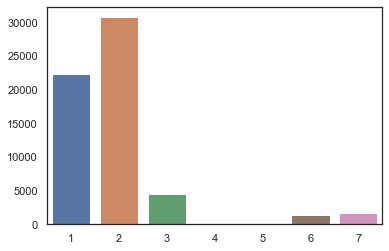

In [472]:
# Assign class labes according with the probabilities
y_h_train3_m_rw_v = pd.Series(prob_to_value(y_h_train3_m_rw, [1,2,3,4,5,6,7]))
y_h_train3_m_rw_v_vc = y_h_train3_m_rw_v.value_counts()
print(y_h_train3_m_rw_v_vc)
sns.barplot(x=y_h_train3_m_rw_v_vc.index, y=y_h_train3_m_rw_v_vc)

Now we see that the distribution of the predicted classes in the training data set is similar to the actual one on observed values of conver type. The confusion matrix, is also a bit better althoug for classes 4 and 5 make hundreds of mistakes in the predictions.

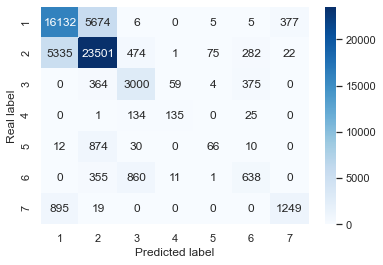

In [473]:
cm =  confusion_matrix(y_pred=y_h_train3_m_rw_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) ## From the utils folder class lables are class_labels = ["email","spam"]

In [485]:
print(accuracy_score(y_train_m, y_h_train3_m_v))
print(accuracy_score(y_train_m, y_h_train3_m_rw_v))

0.615119824279579
0.733059043372783


After the adjustment of the probabilities the accuracy score (the same as the kaggle's competition) increases from 0.61 to 0.73 which is a good improvement

In [486]:
print(classification_report(y_train_m, y_h_train3_m_rw_v))

              precision    recall  f1-score   support

           1       0.72      0.73      0.72     22199
           2       0.76      0.79      0.78     29690
           3       0.67      0.79      0.72      3802
           4       0.66      0.46      0.54       295
           5       0.44      0.07      0.12       992
           6       0.48      0.34      0.40      1865
           7       0.76      0.58      0.66      2163

    accuracy                           0.73     61006
   macro avg       0.64      0.54      0.56     61006
weighted avg       0.73      0.73      0.73     61006



Although this model has an accuracy (number of right predictions over total predictions) of 73%, when looking into the validation scores for each class we find the the model is very bad for predicting cover type 5 (Aspen), specially by using the recall value (0.07) which is the ratio of correctly predicted values of class 5 over all of the actual observations in that class.

#### Predictions for test data

2    6586
1    4819
3     917
7     349
6     320
4      48
5      34
dtype: int64


<AxesSubplot:>

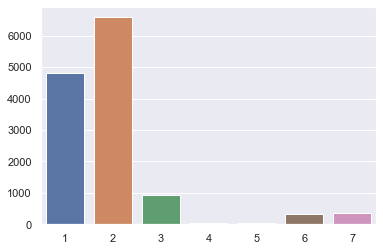

In [478]:
# Reweight and get the values in the test data
y_h_test3_m_rw = reweight_proba_multy(y_h_test3_m, q, r)

y_h_test3_m_rw_v = pd.Series(prob_to_value(y_h_test3_m_rw, [1,2,3,4,5,6,7]))
y_h_test3_m_rw_v_vc = y_h_test3_m_rw_v.value_counts()

print(y_h_test3_m_rw_v_vc)
sns.barplot(x=y_h_test3_m_rw_v_vc.index, y=y_h_test3_m_rw_v_vc)

In [480]:
# Saving the model and the data
joblib.dump(lr_31, 'models/lr_31.sav')

# Saving the data that the model uses
X_train_3.to_csv('data/output/lr_31_X_train.csv', index=False)
y_train_m.to_csv('data/output/lr_31_y_train.csv', index=False)
X_test_2.to_csv('data/output/lr_31_X_test.csv', index=False)

# Produce .csv for kaggle  
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test3_m_rw_v})
test_predictions_submit.to_csv("data/output/lr_31_y_hat_test.csv", index = False)

In [428]:
# Lets submit the predictions without reweight the probabilities
y_h_test3_m_v = lr_31.predict(X_test_2)
print(pd.Series(y_h_test3_m_v).value_counts())
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test3_m_v})
test_predictions_submit.to_csv("data/output/lr_31_y_hat_test2.csv", index = False)

1    4688
2    4325
5    1467
7     994
6     754
3     665
4     180
dtype: int64


Similar to what was found in the insample evaluation of the model by using the accuracy score, in the public leader board the default predictions of the model get a score of 0.62239 while after the adjustment of probabilities the accuracy inproves to 0.73898. A similar behaviuor of the scores over insample and outsample data is a good sign of not overfitting.

### Resampling and class balancing exploration

My next step is try to find a way to improve the accuracy of the model by dealing with the class balancing of the training data.

Since in sklearn by using the option class_weight = 'balance' uses a different data set with balanced classes, I would like to explore the idea of build this new dataset by my self and see if this can improve the performance of the logistic model. For this, I am going to use the library imbalaced-learn. ps://imbalanced-learn.org/stable/user_guide.html#user-guide

#### Oversampling smaller classes with Synthetic Minority Oversampling Technique (SMOTE)

According with this [post](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/) Smote is a technique to resampling the minority classes by: _"randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors"_

The steps that SMOTE algorithm follows are:

- _Choose a minority class as the input vector_
- _Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)_
- _Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor_
- _Repeat the steps until data is balanced_


Balancing the data set with the library (imbalance-learn) is pretty straighforward, as I will show in the next code:

In [245]:
smote = SMOTE(random_state=123, n_jobs = -1) # Creation of the element SMOTE

# fit predictor and target variable
X_train_3_rs, y_train_m_rs = smote.fit_resample(X_train_3, y_train_m) # Fit the data into train X's and y

In [165]:
print(X_train_3.shape, y_train_m.shape)
print(X_train_3_rs.shape, y_train_m_rs.shape)
print(y_train_m_rs.value_counts())

(61006, 86) (61006,)
(207830, 86) (207830,)
1    29690
2    29690
3    29690
4    29690
5    29690
6    29690
7    29690
Name: Cover_Type, dtype: int64


Now we have more 207.000 observations and all of the classes have the same amount of rows. **The data is balanced!**

Let's see briefly what is the distribution of the observations for the resampled data

In [166]:
# New data frame with the resampled data
df4 = X_train_3_rs.copy()
df4['Cover_Type'] = y_train_m_rs

In [167]:
# Data frame with the before resampling
df4_b = X_train_3.copy()
df4_b['Cover_Type'] = y_train_m

In [168]:
numeric_features = ['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Soil_Type_N']

The next matrix of plots will show the distribution of the target variable (Cover Type) for any numeric feature of the data set, before resampling the data.

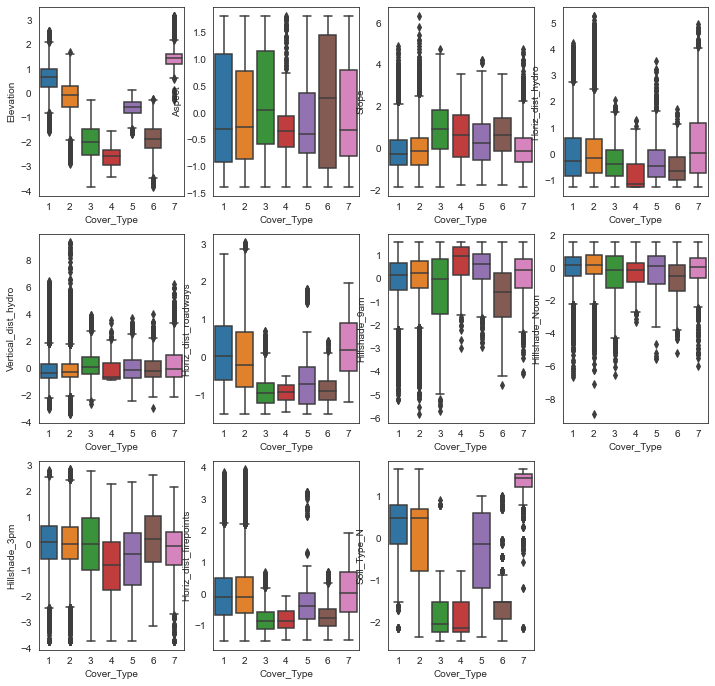

In [42]:
cp.target_features_plot(df4_b, 'Cover_Type', numeric_features, 'boxplot')

Now we will se the distribution after resampling the data for balancing the classes

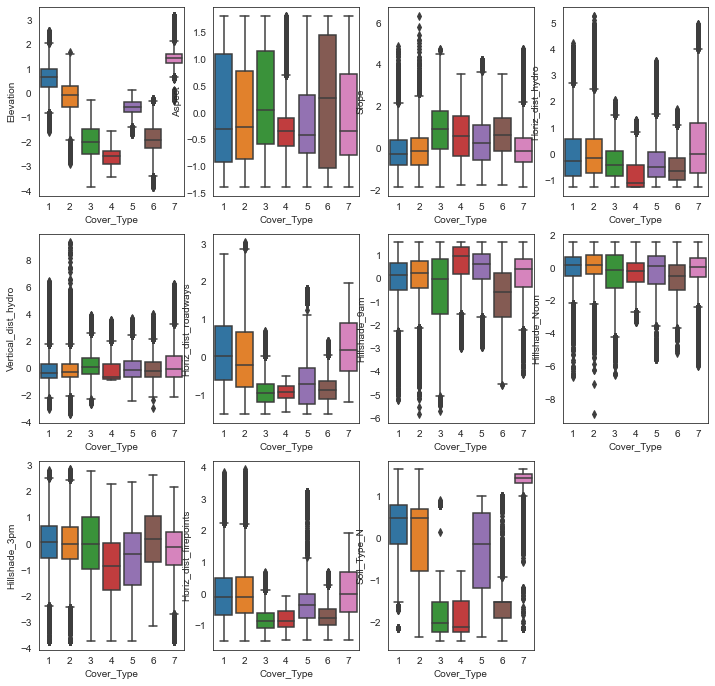

In [43]:
cp.target_features_plot(df4, 'Cover_Type', numeric_features, 'boxplot')

We can see that according to the plots above the data with the balanced classes follows the same distribution as the actual training data. In order to see if this resampling is better that the one that sklearn implements I will run a model and see if the resampled data is better to train a model a predict cover types.

#### Measuring the improvement over the predictions

The best way to see if the resampling using the SMOTE technic is good is by runing a model and measuring the improvement in the validation metrics

In [56]:
lr_test_rs = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', 
                           max_iter=10000)

In [57]:
# Measuring the accuracy with cross validation over training data

kf = KFold(n_splits=5, shuffle=True, random_state=123)
accuracy_scores = []

for tr_ind, val_ind in kf.split(X_train_3_rs): # Creation of train and validation (test) data for the actual traning data
    # Creation of the training and validations data sets with X and y
    X_tr, X_val = X_train_3_rs.iloc[tr_ind], X_train_3_rs.iloc[val_ind]
    y_tr, y_val = y_train_m_rs.iloc[tr_ind], y_train_m_rs.iloc[val_ind]
    
    # Model
    lr_test_rs.fit(X_tr, y_tr) # Fit the model
    y_val_p_hat = lr_test_rs.predict_proba(X_val) # Make predictions
    y_val_p_hat_rw = reweight_proba_multy(y_val_p_hat, q, r)# Reweight probabilities
    y_val_hat_rw = prob_to_value(y_val_p_hat_rw, [1,2,3,4,5,6,7])# Create class values from reweighted probabilities
    accu_score = accuracy_score(y_val, y_val_hat_rw)
    print(accu_score)
    accuracy_scores.append(accu_score) # Compute accuracy and save it in a list   

0.5776355675311553
0.5731366982630034
0.5766973006784392
0.5703700139537121
0.5779483231487273


We see that the accuracy is very poor, there should be something wrong in this approach of cross validation. Lest try to do it without adjustint the probabilities

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
accuracy_scores = []

for tr_ind, val_ind in kf.split(X_train_3_rs):
    # Creation of the training and validations data sets with X and y
    X_tr, X_val = X_train_3_rs.iloc[tr_ind], X_train_3_rs.iloc[val_ind]
    y_tr, y_val = y_train_m_rs.iloc[tr_ind], y_train_m_rs.iloc[val_ind]
    
    # Model
    lr_test_rs.fit(X_tr, y_tr) # Fit the model
    y_val_p_hat = lr_test_rs.predict(X_val) # Make predictions
    #y_val_p_hat_rw = reweight_proba_multy(y_val_p_hat, q, r)# Reweight probabilities
    #y_val_hat_rw = prob_to_value(y_val_p_hat_rw, [1,2,3,4,5,6,7])# Create class values from reweighted probabilities
    accu_score = accuracy_score(y_val, y_val_p_hat)
    print(accu_score)
    accuracy_scores.append(accu_score) # Compute accuracy and save it in a list   

0.7488812972140692
0.7511668190347881
0.7550161189433672
0.7530914689890776
0.7521291440119329


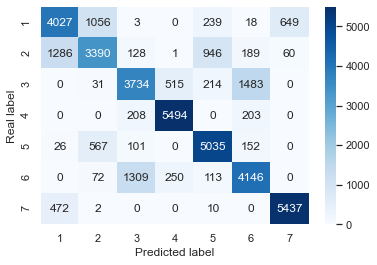

In [60]:
cm =  confusion_matrix(y_pred=y_val_p_hat, y_true=y_val, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) ## From the utils folder class lables are class_labels = ["email","spam"]

In [59]:
print(classification_report(y_val, y_val_p_hat))

              precision    recall  f1-score   support

           1       0.69      0.67      0.68      5992
           2       0.66      0.56      0.61      6000
           3       0.68      0.62      0.65      5977
           4       0.88      0.93      0.90      5905
           5       0.77      0.86      0.81      5881
           6       0.67      0.70      0.69      5890
           7       0.88      0.92      0.90      5921

    accuracy                           0.75     41566
   macro avg       0.75      0.75      0.75     41566
weighted avg       0.75      0.75      0.75     41566



It looks like over unseen data that is already balanced the predictions al slightly better, however what would be the effect over unseen unbalanced data such as the test??. Do we have to reweight probabilities or not, let's see by test and error and the information that the public leaderboard can give me

1    4704
2    4497
5    1335
7     946
3     741
6     717
4     133
dtype: int64


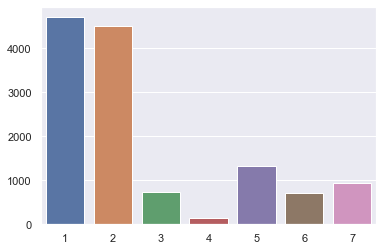

In [64]:
# Predictions in test data without reweight
y_h_test4_m_v = lr_test_rs.predict(X_test_2)
print(pd.Series(y_h_test4_m_v).value_counts())

sns.barplot(x=pd.Series(y_h_test4_m_v).value_counts().index, y=pd.Series(y_h_test4_m_v).value_counts())

test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test4_m_v})
test_predictions_submit.to_csv("data/output/lr_test_rs_y_hat_test2.csv", index = False)

The score of these predictions is 0.63846, which looks like a sign for reweighting the probabilities and see how much it improve in the public leaderboard

2    6639
1    4791
3     910
7     335
6     306
4      54
5      38
dtype: int64


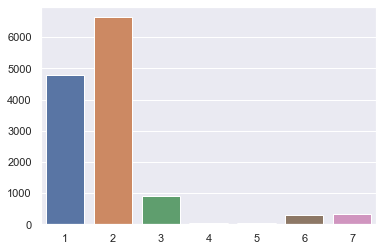

In [65]:
y_h_test4_m_p = lr_test_rs.predict_proba(X_test_2)
y_h_test4_m_p_rw = reweight_proba_multy(y_h_test4_m_p, q, r)
y_h_test4_m_rw = prob_to_value(y_h_test4_m_p_rw, [1,2,3,4,5,6,7]) 

print(pd.Series(y_h_test4_m_rw).value_counts())
sns.barplot(x=pd.Series(y_h_test4_m_rw).value_counts().index, y=pd.Series(y_h_test4_m_rw).value_counts())

test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test4_m_rw})
test_predictions_submit.to_csv("data/output/lr_test_rs_y_hat_test.csv", index = False)

Now everything makes sense, we did not need to adjust the probabilites and classes in training balaced data but in test data as it has a different distribution (unbalanced data) we do have to adjust probabilites.

In the public leaderboard the score is 0.73867 of the adjusted predictions from the resampled data  is sligtly less that the better one using the option class_weight = 'balance' in sklearn. It looks like I did the same as before but with a different method, at least now I think that I undestood better the process of class resampling of sklearn.

### Model 3 of multiclass classification

Now I want to try with new features and improve the accuracy of the predictions. For this I will use the distance to hydrographic sources and I will create more features base of the interaction of Elevation with other characteristics.

In [197]:
# New features with the variable distance to water sources 

print(X_train_3.shape, X_test_2.shape)

def water_features(df):
    df['min_dist_hydro'] = df[['Horiz_dist_hydro','Vertical_dist_hydro']].min(axis=1)
    df['max_dist_hydro'] = df[['Horiz_dist_hydro','Vertical_dist_hydro']].max(axis=1)
    df['mean_dist_hydro'] = df[['Horiz_dist_hydro','Vertical_dist_hydro']].mean(axis=1)
    return df
    
X_train_3 = water_features(X_train_3)
X_test_2 = water_features(X_test_2)

print(X_train_3.shape, X_train_2.shape)

(61006, 89) (13073, 89)
(61006, 89) (61006, 89)


In [198]:
# Inclution of the interaction between the categorical Soil_Type and Wilderness_Area

print(df_test.shape)
print(df_train.shape)

df_wild_soil = pd.concat([df_train.drop('Cover_Type', axis=1), df_test], axis = 0)
df_wild_soil.set_index('Index', inplace=True)

df_wild_soil = df_wild_soil[['Wilderness_Area', 'Soil_Type']]
df_wild_soil['wild_area_soil_type'] = df_wild_soil['Wilderness_Area'].astype(str) + '_' + df_wild_soil['Soil_Type'].astype(str)

print(df_wild_soil['wild_area_soil_type'].nunique())

df_wild_soil = pd.get_dummies(df_wild_soil, columns = ['wild_area_soil_type'])
df_wild_soil.drop(['Wilderness_Area', 'Soil_Type'], axis=1, inplace=True)

print(df_wild_soil.shape)
df_wild_soil.head()

(13073, 13)
(61006, 14)
74
(74079, 74)


,wild_area_soil_type_1_12,wild_area_soil_type_1_16,wild_area_soil_type_1_18,wild_area_soil_type_1_19,wild_area_soil_type_1_20,wild_area_soil_type_1_22,wild_area_soil_type_1_23,wild_area_soil_type_1_24,wild_area_soil_type_1_29,wild_area_soil_type_1_30,...,wild_area_soil_type_4_10,wild_area_soil_type_4_11,wild_area_soil_type_4_14,wild_area_soil_type_4_16,wild_area_soil_type_4_17,wild_area_soil_type_4_2,wild_area_soil_type_4_3,wild_area_soil_type_4_4,wild_area_soil_type_4_5,wild_area_soil_type_4_6
Index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
# Add the new columns into train and test data
X_train_4 = pd.merge(X_train_3, df_wild_soil, left_index = True, right_index = True) 
X_test_4 = pd.merge(X_test_2, df_wild_soil, left_index = True, right_index = True)

print(X_train_4.shape, X_test_4.shape)

(61006, 163) (13073, 163)


In [209]:
# As the last step for the creation of features I will create interactions between Elevation and all of the rest
# So I will double the number of features


for col in [i for i in X_train_4.columns if i not in 'Elevation']:
    X_train_4['Ele_'+str(col)] = X_train_4['Elevation'] * X_train_4[col]
    X_test_4['Ele_'+str(col)] = X_test_4['Elevation'] * X_test_4[col]

print(X_train_4.shape)
print(X_test_4.shape)

(61006, 315)
(13073, 315)


#### Running the new model

In [212]:
lr_41 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', 
                           max_iter=10000,
                           class_weight='balanced')

# Fiting logistic regression
lr_41.fit(X_train_4, y_train_m)   

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

#### Insample validation

2    31303
1    21876
3     4396
7     1728
6     1278
5      214
4      211
dtype: int64


<AxesSubplot:>

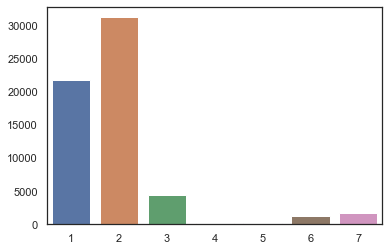

In [213]:
# Predicted probabilites with reweight and new class predicted values
y_h_train4_m = lr_41.predict_proba(X_train_4) # predicted by defaulg
y_h_train4_m_rw = reweight_proba_multy(y_h_train4_m, q, r) # reweight of proba
y_h_train4_m_rw_v = pd.Series(prob_to_value(y_h_train4_m_rw, [1,2,3,4,5,6,7])) # new values 

y_h_train4_m_rw_v_vc = y_h_train4_m_rw_v.value_counts()
print(y_h_train4_m_rw_v_vc)
sns.barplot(x=y_h_train4_m_rw_v_vc.index, y=y_h_train4_m_rw_v_vc)

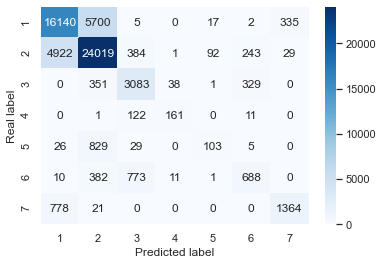

In [214]:
cm =  confusion_matrix(y_pred=y_h_train4_m_rw_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) 

In [215]:
print(classification_report(y_train_m, y_h_train4_m_rw_v))

              precision    recall  f1-score   support

           1       0.74      0.73      0.73     22199
           2       0.77      0.81      0.79     29690
           3       0.70      0.81      0.75      3802
           4       0.76      0.55      0.64       295
           5       0.48      0.10      0.17       992
           6       0.54      0.37      0.44      1865
           7       0.79      0.63      0.70      2163

    accuracy                           0.75     61006
   macro avg       0.68      0.57      0.60     61006
weighted avg       0.74      0.75      0.74     61006



The insample accuracy of this model is the same as the model with the resampled data, and better that the first model of multi class classification.

#### Predictions over the test data

2    6724
1    4689
3     882
7     368
6     307
4      57
5      46
dtype: int64


<AxesSubplot:>

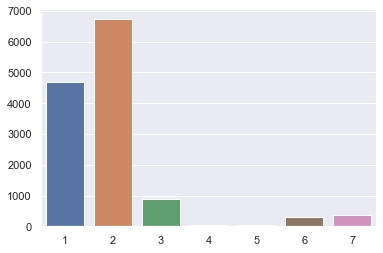

In [216]:
# Reweight and get the values in the test data
y_h_test4_m = lr_41.predict_proba(X_test_4) # predicted by defaulg
y_h_test4_m_rw = reweight_proba_multy(y_h_test4_m, q, r)

y_h_test4_m_rw_v = pd.Series(prob_to_value(y_h_test4_m_rw, [1,2,3,4,5,6,7]))
y_h_test4_m_rw_v_vc = y_h_test4_m_rw_v.value_counts()

print(y_h_test4_m_rw_v_vc)
sns.barplot(x=y_h_test4_m_rw_v_vc.index, y=y_h_test4_m_rw_v_vc)

In [217]:
# Saving the model and the data
joblib.dump(lr_41, 'models/lr_41.sav')

# Saving the data that the model uses
X_train_4.to_csv('data/output/lr_41_X_train.csv', index=False)
y_train_m.to_csv('data/output/lr_41_y_train.csv', index=False)
X_test_4.to_csv('data/output/lr_41_X_test.csv', index=False)

# Produce .csv for kaggle  
test_predictions_submit = pd.DataFrame({"Index": X_test_4.index, "Cover_Type": y_h_test4_m_rw_v})
test_predictions_submit.to_csv("data/output/lr_41_y_hat_test.csv", index = False)

In the public leaderboard this model gets an accuracy score of 0.74969 very consistent with the insample score and the best so far. However, since I haven't run a grid search over this model I think there is still room for improve the performance of this model.

Due to the huge amount of variables of this new model 315, I will not run Grid Search using the Lasso penalty, because takes more time to find its best value (the absolute value of $\beta$ is not as easy to differentiate as its squared value).

**Warning**: Since the score of the kaggle competition for the multiclass taks is accuracy, this metric is sensitive to the adjustments in the probabilities for imbalances classes. Therefore, the best model according in terms of accuracy according with the grid search can not be the best one after the reweigth of probabilities. However I will perfomr the Grid Search using the accuracy as score.

#### Grid search to find best values of C

In [225]:
# Running the grid search
lr_3 = LogisticRegression( fit_intercept=True, 
                           penalty = 'l2',
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', max_iter=10000,
                           class_weight='balanced')


alphas = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])

tuned_parameters = [{'C': alphas}] 

n_folds = 5

lr_gs3 = GridSearchCV(lr_3, tuned_parameters, cv=n_folds, scoring='accuracy', refit=False, verbose = 3)

In [226]:
lr_gs3.fit(X_train_4, y_train_m)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .........................................C=0.01; total time=  55.6s
[CV 2/5] END .........................................C=0.01; total time=  55.5s
[CV 3/5] END .........................................C=0.01; total time=  52.6s
[CV 4/5] END .........................................C=0.01; total time=  54.5s
[CV 5/5] END .........................................C=0.01; total time=  55.5s
[CV 1/5] END .........................................C=0.05; total time= 1.7min
[CV 2/5] END .........................................C=0.05; total time= 1.7min
[CV 3/5] END .........................................C=0.05; total time= 1.5min
[CV 4/5] END .........................................C=0.05; total time= 1.5min
[CV 5/5] END .........................................C=0.05; total time= 1.5min
[CV 1/5] END ..........................................C=0.1; total time= 2.2min
[CV 2/5] END ...................................

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000,
                                          multi_class='multinomial',
                                          solver='newton-cg'),
             param_grid=[{'C': array([1.e-02, 5.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 1.e+00, 5.e+00, 1.e+01, 1.e+02])}],
             refit=False, scoring='accuracy', verbose=3)

In [227]:
print(lr_gs3.best_params_)

{'C': 100.0}


After more that 24 hours running it says that the best value of c is 100 (the largest one) which implies that I should include more values of C higher that 100 to keep searching for the best parameters. However due that by increasing the value of C the regularization strengh decreases the models will take more time to run and at the due date for this project is tonight, so there will be no chances to run models that take more that one hour.

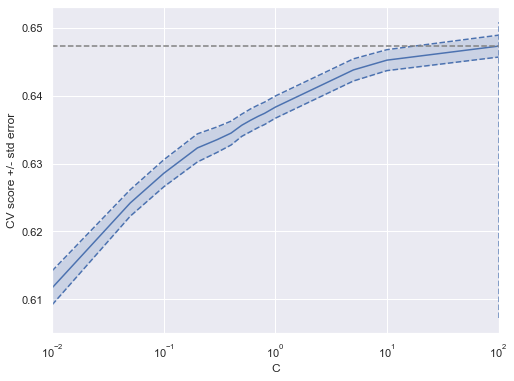

In [231]:
# Detailed reulst of grid search over penalty l1
best_params_gs3 = lr_gs3.best_params_['C']
cv_results_gs3 = pd.DataFrame(lr_gs3.cv_results_)
scores_gs3 = cv_results_gs3['mean_test_score']
std_error_gs2 = cv_results_gs3['std_test_score'] / np.sqrt(5)
alphas_gs3 = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])

cp.grid_serach_dt(scores_gs3, std_error_gs3, alphas_gs3, best_params_gs3)

The grahp above shows how the accuracy of the model increase as the value of C increases, given that I haven't found a maximun I shoul include more values of C in the grid search. However, I prefer tu run a model with a value close to 10 and from which I already know the average time of running. For this reason I choose to use 10 as the value of c for the final model.

#### Running a model with a value of 10 for C

In [232]:
lr_51 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 10,
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', 
                           max_iter=10000,
                           class_weight='balanced')

# Fiting logistic regression
lr_51.fit(X_train_4, y_train_m)  

LogisticRegression(C=10, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

2    31174
1    21627
3     4339
7     1917
6     1391
5      302
4      256
dtype: int64


<AxesSubplot:>

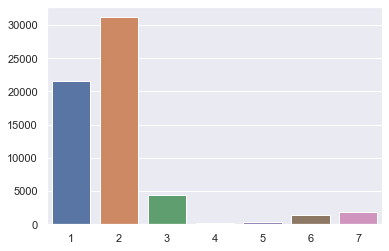

In [233]:
# Predicted probabilites with reweight and new class predicted values
y_h_train5_m = lr_51.predict_proba(X_train_4) # predicted by defaulg
y_h_train5_m_rw = reweight_proba_multy(y_h_train5_m, q, r) # reweight of proba
y_h_train5_m_rw_v = pd.Series(prob_to_value(y_h_train5_m_rw, [1,2,3,4,5,6,7])) # new values 

y_h_train5_m_rw_v_vc = y_h_train5_m_rw_v.value_counts()
print(y_h_train5_m_rw_v_vc)
sns.barplot(x=y_h_train5_m_rw_v_vc.index, y=y_h_train5_m_rw_v_vc)

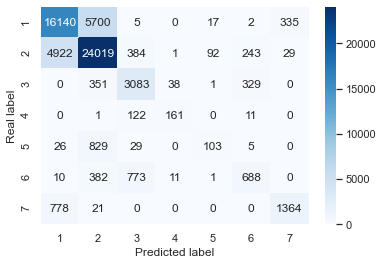

In [234]:
cm =  confusion_matrix(y_pred=y_h_train4_m_rw_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) 

In [235]:
print(classification_report(y_train_m, y_h_train5_m_rw_v))

              precision    recall  f1-score   support

           1       0.74      0.72      0.73     22199
           2       0.77      0.81      0.79     29690
           3       0.71      0.81      0.76      3802
           4       0.73      0.64      0.68       295
           5       0.49      0.15      0.23       992
           6       0.56      0.42      0.48      1865
           7       0.77      0.68      0.72      2163

    accuracy                           0.75     61006
   macro avg       0.68      0.60      0.63     61006
weighted avg       0.74      0.75      0.74     61006



According to the insample evaluation of the model, this is slighty better that model 1 of multiclass classification if we see the scores for classes 5 and 6, although in the end the accuraccy is the same.

2    6719
1    4628
3     866
7     404
6     337
4      65
5      54
dtype: int64


<AxesSubplot:>

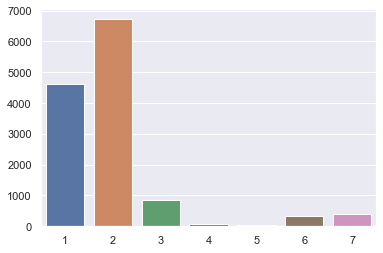

In [236]:
# Reweight and get the values in the test data
y_h_test5_m = lr_51.predict_proba(X_test_4) # predicted by defaulg
y_h_test5_m_rw = reweight_proba_multy(y_h_test5_m, q, r)

y_h_test5_m_rw_v = pd.Series(prob_to_value(y_h_test5_m_rw, [1,2,3,4,5,6,7]))
y_h_test5_m_rw_v_vc = y_h_test5_m_rw_v.value_counts()

print(y_h_test5_m_rw_v_vc)
sns.barplot(x=y_h_test5_m_rw_v_vc.index, y=y_h_test5_m_rw_v_vc)

In [238]:
# Saving the model and the data
joblib.dump(lr_51, 'models/lr_51.sav')

# Saving the data that the model uses
X_train_4.to_csv('data/output/lr_51_X_train.csv', index=False)
y_train_m.to_csv('data/output/lr_51_y_train.csv', index=False)
X_test_4.to_csv('data/output/lr_51_X_test.csv', index=False)

# Produce .csv for kaggle  
test_predictions_submit = pd.DataFrame({"Index": X_test_4.index, "Cover_Type": y_h_test5_m_rw_v})
test_predictions_submit.to_csv("data/output/lr_51_y_hat_test.csv", index = False)

This final model gets a accuracy score of 0.74984, so far the best but it is still under 0.75 of accuracy.

## Final remarks

This notebook showed the using of logistic regression to predict Forest Cover type under a binary setting as well as with a multiclass setting. Among the different elements that were used in this starting exploragion on the algoritm of logistic regression for machine learning, I implemented the following

- Data exploration
- Lasso and Ridge regularization
- Feature engineering
- Grid search
- Dealing with class imbalance

The code follows an DRYE structucture and modules with own classes and functions were built.

The results of the models run rearch an AUC for binary class classification of 0.98 while in the multiclass classificaiton the accuracy score is almost 0.75.